In [1]:
import json
import uuid
import shapely
import datetime
import math
import random
import pyproj
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from pathlib import Path
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
from shapely.ops import transform
from geojson import Point, Feature, FeatureCollection, dump
from data_models import CreateBaseRunsLiftsGraph, GetConnections, CreateRunsLiftsGraph, CreateRunsLiftsNodesGraph, CreateNodesGraph





dir = "/Users/sebastian/Documents/PrivateProjects/SkiNavData/Data/"
dir_resorts = "/Users/sebastian/Documents/PrivateProjects/SkiNavData/SkiResorts/"


# get from https://epsg.io/
# UoM must be meters!
# crs = "27561" France
crs = 21781

In [11]:
features = ["id", "name", "ref", "ski_area_id", "connection_type", "difficulty",
            "duration", "distance", "geometry", "start", "end", "status"]

## Load and select ski areas

In [4]:
filename = "ski_areas.geojson"
file = open(dir + filename)
ski_areas = gpd.read_file(file)
ski_areas = ski_areas[['id', 'name', 'runConvention']]
ski_areas = ski_areas.dropna(subset='name')

In [5]:
name = 'Grindelwald'
print(ski_areas[ski_areas.name.str.contains(name)])
ski_area_id = ski_areas[ski_areas.name.str.contains(name)].id.values.tolist()
ski_area_name = ski_areas[ski_areas.name.str.contains(name)].name.values.tolist()
print(ski_area_id, ski_area_name)

                                           id  \
8    17b19c745f7d69545421bdb985f0b981abfc70ae   
407  1871bd97633b45248e93e03d11f44d94caae83fc   
414  1d111e0379650f6a9186eaa3d21dadf973340c88   

                                                  name runConvention  
8            Grindelwald - Männlichen (Schlittelpiste)        europe  
407                                  Grindelwald First        europe  
414  Grindelwald - Wengen (Kleine Scheidegg - Männl...        europe  
['17b19c745f7d69545421bdb985f0b981abfc70ae', '1871bd97633b45248e93e03d11f44d94caae83fc', '1d111e0379650f6a9186eaa3d21dadf973340c88'] ['Grindelwald - Männlichen (Schlittelpiste)', 'Grindelwald First', 'Grindelwald - Wengen (Kleine Scheidegg - Männlichen)']


In [6]:
ski_area_id = ski_area_id
#ski_area_name = ski_area_name[2]
ski_area_name = 'Kleine Scheidegg - Männlichen - First'
print(ski_area_id, ski_area_name)

['17b19c745f7d69545421bdb985f0b981abfc70ae', '1871bd97633b45248e93e03d11f44d94caae83fc', '1d111e0379650f6a9186eaa3d21dadf973340c88'] Kleine Scheidegg - Männlichen - First


## Data processing steps

1. Load runs
2. Where needed do manual renaming, splitting, and appending (log changes). Take notes if linestring must be modified.
3. Load lifts
4. Where needed do manual renaming and splitting (log changes). Take notes if linestring must be modified.
5. Automatically generate points
6. Automatically generate nodes with a buffer of 2m
7. Automatically derive unconnected start and end points of runs and lifts
8. Examine visually these points and take notes if either new generic runs need to be added or existing ones be modified RunsLiftsGraph and NodesGraph_tmp
9. Perform visual examination in geojson.io (- crossings are a node - red and black runs don't block green and blue runs (primarely end of runs, start of lifts - accessibility start point run from intersection)
10. Perform all changes in geojson.io
11. Load ski region specific geojson
12. Run steps 5, 6, 7, 9
13. Automatically generate NodeGraph
14. Perform sensitivity checks on some selected nodes

## 1. Load runs

In [7]:
def get_id(data):
    json_file = json.loads(data)
    if len(json_file) > 0:
        id = json_file[0].get("properties").get("id")
    else:
        id = pd.NA
    return id

def get_uses(data):
    if "downhill" in data:
        uses = "downhill"
    else:
        uses = "else"
    return uses

In [8]:
filename = "runs.geojson"
file = open(dir + filename)
runs = gpd.read_file(file)

In [12]:
runs["ski_area_id"] = runs.skiAreas.apply(lambda x: get_id(x))
# only keep run within ski area
runs = runs[runs.ski_area_id.isin(ski_area_id)]
runs["uses"] = runs.uses.apply(lambda x: get_uses(x))
runs["name"] = np.where((~runs.name.isnull()) & (runs.name.str.isdigit()), # if name is not None and a digit -> Ski run digit
                        "Ski run " + runs.name, np.where((runs.name.isnull()) & (runs.ref.str.isdigit()), # if name is None but ref is digit -> Ski run digit
                                                         "Ski run " + runs.ref, np.where((runs.name.isnull()) & (runs.ref.isnull()),
                                                                                         None, runs.name))) # if name and ref None -> None ELSE -> run name
runs["name"] = runs.name.apply(lambda x: x if pd.isna(x) or 'Ski run' in x else pd.Series(x).str.replace(r'\d+', '', regex=True)[0])
runs["name"] = runs.name.str.strip()
# remove runs with no elevationprofile
runs = runs[runs.elevationProfile.notnull()]
# only keep runs with defined difficulty levels
runs = runs[runs.difficulty.isin(["novice", "easy", "intermediate", "advanced"])]
# only keep downhill runs
runs = runs[runs.uses=="downhill"]
# set new CRS
runs = runs.to_crs(crs)
# get length of run
runs["distance"] = runs.geometry.length
# get start coordinate
runs["start"] = runs.geometry.apply(lambda x: Point(x.coords[0]))
# get end coordinate
runs["end"] = runs.geometry.apply(lambda x: Point(x.coords[-1]))
# set connection type to run
runs["connection_type"] = "run"
# calculate duration be assuming an average speed of 25km/h or 7m/s
runs["duration"] = runs["distance"] / 7
# return defined features
runs = runs[features]
print("Total number of runs in ski resort:", len(runs))

Total number of runs in ski resort: 182


In [13]:
def get_run_order(data, candidate_runs, rotation=-10):
    data = data[data.name.isin(candidate_runs)]
    ax = data.geometry.plot(figsize=(10, 10))
    for idx, row in data.iterrows():
        # Get the first point of the line segment (this assumes the geometry is a LineString)
        x_start = row.start.x
        y_start = row.start.y
        # Add the annotation text
        ax.text(x_start, y_start, row['id'], fontsize=8, ha='right', color='black', rotation=rotation)
    print("Not operational runs:", data[data.status!="operating"].name)
    print(data.id.unique())
    plt.show()

def combine_ski_runs(data, ordered_ids, new_name, difficulty, status):
    original_data = data.copy()
    data = runs[runs.id.isin(ordered_ids)]
    data_ordered = data.set_index('id').loc[ordered_ids].reset_index()
    run_id = data_ordered.id.iloc[0]
    ski_area_id = data_ordered.ski_area_id.iloc[0]
    connection_type = data_ordered.connection_type.iloc[0]
    distance = data_ordered["distance"].sum()
    duration = data_ordered.duration.sum()
    start_point = data_ordered.iloc[0].start
    end_point = data_ordered.iloc[0].end
    
    coordinates = []
    for idx, row in data_ordered.iterrows():
        coordinates.extend(list(row.geometry.coords))
    linestring = LineString(coordinates)

    new_entry = gpd.GeoDataFrame({"id": run_id,
                                    "name": new_name,
                                    "ski_area_id": ski_area_id,
                                    "connection_type": connection_type,
                                    "difficulty": difficulty,
                                    "distance": distance,
                                    "duration": duration,
                                    "geometry": linestring,
                                    "start": start_point,
                                    "end": end_point,
                                    "status": status}, index=[0])

    data_cleaned = original_data[~original_data.id.isin(ordered_ids)]
    data_cleaned = pd.concat([data_cleaned, new_entry])

    new_entry.geometry.plot()
    print("Runs before cleaning:", len(original_data))
    print("Runs after cleaning:", len(data_cleaned))

    return data_cleaned

## 2. Manual renaming, splitting, and appending of runs

1. Look up duplicated ski runs using their name
2. Derive their run IDs
3. Append runs together, split them, or rename them to Ski run

In [ ]:
candidate_runs = ['Ski run 8',]

get_run_order(runs, candidate_runs, -10)

In [ ]:
ordered_ids = ['89b9e6df26d2cccc92c15a66510fa00edb3155d5']

new_name = 'Gummi Süd'
difficulty = 'intermediate'
status = 'operating'

runs = combine_ski_runs(runs, ordered_ids, new_name, difficulty, status)

Run SECTION - 1 runs_changes_log_SKIRESORT.txt bellow

In [15]:
runs = runs.reset_index(drop=True)

## 3. Load ski lifts

In [16]:
filename = "lifts.geojson"
file = open(dir + filename)
lifts = gpd.read_file(file)

In [17]:
lifts["ski_area_id"] = lifts.skiAreas.apply(lambda x: get_id(x))
lifts = lifts[lifts.ski_area_id.isin(ski_area_id)]
lifts = lifts[lifts.status=='operating']
len(lifts)

34

Check if all lifts have a name otherwise rename them to Lift

In [18]:
def rename_lifts(data, lift_id, new_name):
    data['name'] = np.where(data.id==lift_id, new_name, data.name)

lifts['name'] = np.where(lifts.name.isna(), 'Lift', lifts.name)

## 4. Check for lifts with the same name

Split them if needed and add suffix _1, _2, ...

In [19]:
lifts[lifts.name!='Lift'][lifts[lifts.name!='Lift'].name.duplicated(keep=False)]

,type,liftType,status,name,oneway,ref,description,occupancy,capacity,duration,bubble,heating,detachable,skiAreas,sources,websites,wikidata_id,id,geometry,ski_area_id
1327,lift,gondola,operating,Firstbahn,None,2440,None,6.0,1200.0,1260.0,None,None,None,"[ { ""type"": ""Feature"", ""properties"": { ""id"": ""...","[ { ""type"": ""openstreetmap"", ""id"": ""way\/25076...",[ ],None,37b9fd49af3875c91c16a95a3fda389306bea076,"LINESTRING Z (8.04178 46.62502 1068.00000, 8.0...",1871bd97633b45248e93e03d11f44d94caae83fc
1642,lift,gondola,operating,Männlichenbahn,None,None,None,10.0,1800.0,522.0,None,None,None,"[ { ""type"": ""Feature"", ""properties"": { ""id"": ""...","[ { ""type"": ""openstreetmap"", ""id"": ""way\/27255...",[ ],None,82461e98ce71ec14d2c845c7614311681e625947,"LINESTRING Z (8.01855 46.62469 941.00000, 8.01...",1d111e0379650f6a9186eaa3d21dadf973340c88
8853,lift,gondola,operating,Männlichenbahn,None,None,None,10.0,1800.0,NaN,None,None,None,"[ { ""type"": ""Feature"", ""properties"": { ""id"": ""...","[ { ""type"": ""openstreetmap"", ""id"": ""way\/15453...",[ ],None,5779331ef31e11cd9c8557be2a3c5db4b6e0ca39,"LINESTRING Z (7.97924 46.62134 1619.00000, 7.9...",17b19c745f7d69545421bdb985f0b981abfc70ae
13205,lift,gondola,operating,Männlichenbahn,None,None,None,10.0,1800.0,618.0,None,None,None,"[ { ""type"": ""Feature"", ""properties"": { ""id"": ""...","[ { ""type"": ""openstreetmap"", ""id"": ""way\/28870...",[ ],None,f8723bde0fa32989db381e4b3acef3e895742c29,"LINESTRING Z (7.97892 46.62127 1623.00000, 7.9...",1d111e0379650f6a9186eaa3d21dadf973340c88
17501,lift,gondola,operating,Firstbahn,None,2440,None,6.0,1200.0,180.0,None,None,None,"[ { ""type"": ""Feature"", ""properties"": { ""id"": ""...","[ { ""type"": ""openstreetmap"", ""id"": ""way\/67581...",[ ],None,40256b966978648e2e1014ebe2130d0811c472f6,"LINESTRING Z (8.06526 46.65849 1951.00000, 8.0...",1871bd97633b45248e93e03d11f44d94caae83fc


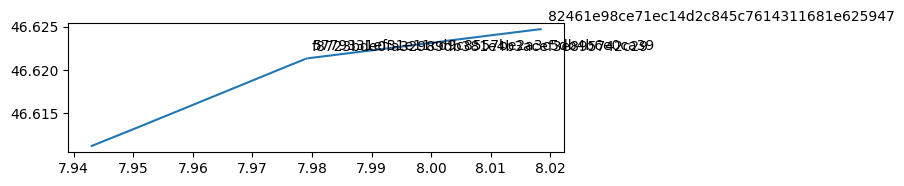

In [43]:
lift_name = "Männlichenbahn"

filtered_lifts = lifts[lifts.name == lift_name]
ax = filtered_lifts.geometry.plot()

for _, lift in filtered_lifts.iterrows():
    first_point = list(lift.geometry.coords)[0][:2] 
    plt.annotate(text=lift.id, 
    xy=first_point, 
    xytext=(first_point[0] + 0.001, first_point[1] + 0.001))
plt.show()

Run SECTION - 2 runs_changes_log_SKIRESORT.txt bellow

In [21]:
# set new CRS
lifts = lifts.to_crs(crs)
# get length of lift
lifts["distance"] = lifts.geometry.length
# get start coordinate
lifts["start"] = lifts.geometry.apply(lambda x: Point(x.coords[0]))
# get end coordinate
lifts["end"] = lifts.geometry.apply(lambda x: Point(x.coords[-1]))
# generate lift linesstring
lifts["geometry"] = lifts.geometry.apply(lambda x: LineString([x.coords[0], x.coords[-1]]))
# set connection type to lift
lifts["connection_type"] = lifts.liftType
# set difficulty to lift
lifts["difficulty"] = "lift"
# calcualte average speed in m/s (distance / duration)
mean_speed = lifts[lifts["duration"].notnull()]["distance"].sum() / lifts[lifts["duration"].notnull()].duration.sum()
lifts["duration"] = np.where(lifts["duration"].isna(), (lifts["distance"] / mean_speed), lifts["duration"])
# return defined features
lifts = lifts[features]

## Concatenate run and lift data

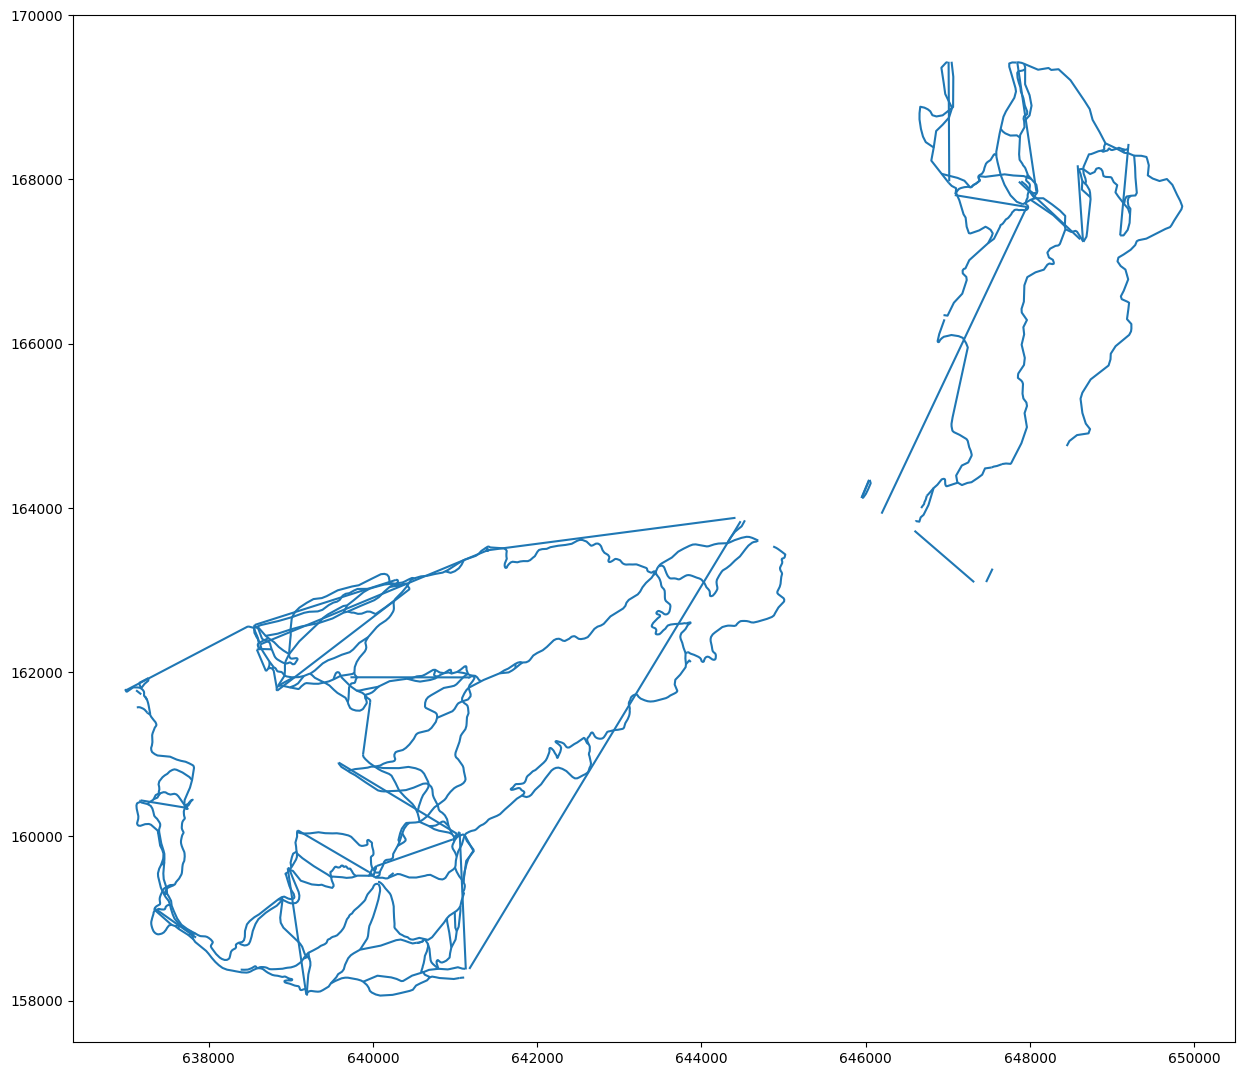

In [22]:
data = pd.concat([lifts, runs])

# quality test if data is correct
data.geometry.plot(figsize=(15, 15))
plt.show()

## 5. Generate points dataset

In [23]:
# transform linestrings to points
points = data.geometry.apply(lambda x: x.coords).rename("point").explode().reset_index().rename(columns={"index": "Index"})
# reset index of original data, needed for merging
data = data.reset_index().rename(columns={"index": "Index"})
# generate unique id for each point
unique_id = []
for i in range(len(points)):
    unique_id.append(str(uuid.uuid4()))
# set point_id
points["point_id"] = unique_id
# merge points data with original data on Index
points = points.merge(data[["id", "name", "Index", "difficulty", "duration",
                            "distance", "connection_type", "start", "end", "status"]], how="left", on="Index")
# transform points data to GeoDataFrame
points = gpd.GeoDataFrame(points, geometry=[Point(x) for x in points.point]).rename(columns={"id": "run_id"})
# get start points of all runs
start_points = points.groupby("run_id").first().reset_index()
start_points["point_type"] = "start"
# get end points of all runs
end_points = points.groupby("run_id").last().reset_index()
end_points["point_type"] = "end"
# combine start and end points
start_end_points = pd.concat([start_points, end_points], axis=0).sort_values(by="run_id")
points["points_by_run"] = points.groupby("run_id").point_id.transform("count")

## 6. Create nodes

In [24]:
def CreateBaseRunsLiftsGraph(points):
    """
    transform pandas dataframe to json of structure
    {'run_id': [{'point_id': '58ec74aa-fc4d-414e-94bd-82bc51cee7db',
        'connection_type': 'run',
        'distance': 4350.170313786595,
        'duration': 621.4529019695136,
        'difficulty': 'intermediate',
        'run_name': 'Grindel',
        'status': 'operating',
        'type': 'point',
        'point_coord': <POINT Z (647894.407 167976.609 2002)>},
        {}]
    }
    """
    RunsLiftsGraph = []
    run_tmp = []
    counter = 1

    for run_id, run_name, point_id, points_by_run, point_coord, connection_type, distance, duration, difficulty, status in list(zip(points.run_id, points["name"], points.point_id, points.points_by_run, points.geometry, points.connection_type, points["distance"], points.duration, points.difficulty, points["status"])):
        if counter < points_by_run:
            run_tmp.append({
                "point_id": point_id,
                "connection_type": connection_type,
                "distance": distance,
                "duration": duration,
                "difficulty": difficulty,
                "run_name": run_name,
                "status": status,
                "type": "point",
                "point_coord": point_coord
            })
            counter += 1

        elif counter == points_by_run:
            run_tmp.append({
                "point_id": point_id,
                "connection_type": connection_type,
                "distance": distance,
                "duration": duration,
                "difficulty": difficulty,
                "run_name": run_name,
                "status": status,
                "type": "point",
                "point_coord": point_coord
            })
            RunsLiftsGraph.append({run_id: run_tmp})

            run_tmp = []
            counter = 1

    return RunsLiftsGraph

In [25]:
BaseRunsLiftsGraph = CreateBaseRunsLiftsGraph(points)

In [26]:
def GetConnections(RunsLiftsGraph, points, custom_buffer, current_run_id=None, run_id_idx=0):
    """
    check for connections between runs and lifts and generate nodes
    loop through all points of runs THEN
    loop through all points of all runs (beside same run or already connected) and check if they are within buffer of start/end point
    """
    def replace_point_id(graph, old_id, new_id):
        for run in graph:
            for point in list(run.values())[0]:
                if point.get("point_id") == old_id:
                    point["point_id" ] = new_id
                    point["type" ] = "node"
        return graph

    replaced_ids = set()
    buffer_zone = 2

    for run_id, point_id_p, coords_p, difficulty_p, duration_p, connection_type_p, name_p, status_p in list(zip(points.run_id, points.point_id, points.geometry, points.difficulty, points.duration, points.connection_type, points["name"], points.status)):
        
        if run_id != current_run_id:
            current_run_id = run_id
            run_id_idx = 0
        else:
            run_id_idx += 1

            
        connected_points = []
        connected_runs = []

        for RunLift in RunsLiftsGraph:
            candidate_run_id = list(RunLift.keys())[0]

            # Skip same run or already connected
            if run_id == candidate_run_id or candidate_run_id in connected_runs:
                continue

            points_in_buffer = []
            for point in list(RunLift.values())[0]:
                distance_to_point = coords_p.distance(point.get("point_coord"))

                buffer_limit = custom_buffer.get(run_id, buffer_zone)

                # check if buffer_limit is a dict if True return value for index
                if type(buffer_limit) is dict:
                    buffer_limit = buffer_limit.get(str(run_id_idx), 2)

                if point_id_p != point.get("point_id") and distance_to_point <= buffer_limit:
                    points_in_buffer.append({
                        "point_id": point.get("point_id"),
                        "distance": distance_to_point
                    })

            # Get closest point in buffer, if any
            if points_in_buffer:
                closest_point = min(points_in_buffer, key=lambda p: p["distance"])
                connected_points.append(closest_point["point_id"])
                connected_runs.append(candidate_run_id)

        # Replace IDs only once per node
        if connected_points:
            node_id = str(uuid.uuid4())
            all_ids_to_replace = connected_points + [point_id_p]

            for match in all_ids_to_replace:
                if match not in replaced_ids:
                    replace_point_id(RunsLiftsGraph, match, node_id)
                    replaced_ids.add(match)

    return RunsLiftsGraph

In [27]:
custom_buffer = {}

ConnectedRunsLiftsGraph = GetConnections(BaseRunsLiftsGraph, points, custom_buffer)

In [54]:
ConnectedRunsLiftsGraph

[{'4fa6f19e164cc25315dac8e95fd8e13e2263aeb8': [{'point_id': 'b5300db5-4abb-4f75-909d-2c30fffa74e9',
    'connection_type': 'cable_car',
    'distance': 1676.5335835395206,
    'duration': 300.0,
    'difficulty': 'lift',
    'run_name': 'Wengen LWM',
    'status': 'operating',
    'type': 'node',
    'point_coord': <POINT Z (636993.771 161779.289 1279)>},
   {'point_id': '1991d5ff-368a-4f97-a8c0-7fc4444f2247',
    'connection_type': 'cable_car',
    'distance': 1676.5335835395206,
    'duration': 300.0,
    'difficulty': 'lift',
    'run_name': 'Wengen LWM',
    'status': 'operating',
    'type': 'node',
    'point_coord': <POINT Z (638479.038 162556.943 2217)>}]},
 {'37b9fd49af3875c91c16a95a3fda389306bea076': [{'point_id': 'c92e3730-5d66-4e42-882a-142142a4d4a8',
    'connection_type': 'gondola',
    'distance': 4238.133395109968,
    'duration': 1260.0,
    'difficulty': 'lift',
    'run_name': 'Firstbahn',
    'status': 'operating',
    'type': 'point',
    'point_coord': <POINT Z (6

## 7. Get unconnected runs and lifts

In [16]:
def GetUnconnectedRunsLifts(Graph):
    unconnected_nodes = []

    for RunLift in Graph:
        run_lift_id = list(RunLift.keys())[0]
        body = list(RunLift.values())[0]

        for idx, point_item in enumerate(body):
            if point_item.get("type") != "node":
                if idx == 0:
                    location = 'start'
                elif idx == len(body) - 1:
                    location = 'end'
                else:
                    continue  # Skip if it's not the first or last point

                run_name = point_item.get("run_name")
                unconnected_nodes.append({run_lift_id: [run_name, location]})

    print("Unconnected start and end points:", len(unconnected_nodes))
    return unconnected_nodes

If the lift starts in the valley it is okay if its start point is not connected (a node)

In [58]:
GetUnconnectedRunsLifts(ConnectedRunsLiftsGraph)

unconnected start and end points:  168


[{'37b9fd49af3875c91c16a95a3fda389306bea076': ['Firstbahn', 'start']},
 {'86545be36f7da71ac0ec5421c70e612f643bcc0d': ['Oberjoch', 'start']},
 {'86545be36f7da71ac0ec5421c70e612f643bcc0d': ['Oberjoch', 'end']},
 {'68b96078767544d31c56b2eeb442ca012430540c': ['Pfingsteggbahn', 'start']},
 {'68b96078767544d31c56b2eeb442ca012430540c': ['Pfingsteggbahn', 'end']},
 {'82461e98ce71ec14d2c845c7614311681e625947': ['Männlichenbahn 1', 'start']},
 {'9b27e1e5b4e355fc43d9803c293a8d53439afa54': ['Schilt', 'start']},
 {'9b27e1e5b4e355fc43d9803c293a8d53439afa54': ['Schilt', 'end']},
 {'14cbd935098d07eaa8a836e13b31e746ce2de6d0': ['Hohwald', 'start']},
 {'e4905203d481ed032bc7b3e28a1d61f816cdfb71': ['Grindel', 'start']},
 {'e4905203d481ed032bc7b3e28a1d61f816cdfb71': ['Grindel', 'end']},
 {'4379b48ba7ca2ae99506e68034aedab4db528755': ['Eigernordwand', 'start']},
 {'ae111b6169359a070d1b68ac0e6e18633fc53ac5': ['Tschuggen', 'start']},
 {'f2b8634a95bb28ae00f07387d268e90a434511ad': ['Bumps', 'start']},
 {'7c3c99e8

#### Examine unconnected lifts
1. Check if the lift is on its own and can be removed
2. Define custom buffer for each of the runs, which weren't excluded but should be connected 
3. Go back to step 'conncatenate runs and lifts'
4. Rerun GetConnections() and GetUnconnectedLifts()

Remove unconnected runs (specific to each ski resort)

Run SECTION - 3 runs_changes_log_SKIRESORT.txt bellow

In [93]:
ConnectedRunsLiftsGraph

[{'4fa6f19e164cc25315dac8e95fd8e13e2263aeb8': [{'point_id': 'b5300db5-4abb-4f75-909d-2c30fffa74e9',
    'connection_type': 'cable_car',
    'distance': 1676.5335835395206,
    'duration': 300.0,
    'difficulty': 'lift',
    'run_name': 'Wengen LWM',
    'status': 'operating',
    'type': 'node',
    'point_coord': <POINT Z (636993.771 161779.289 1279)>},
   {'point_id': '1991d5ff-368a-4f97-a8c0-7fc4444f2247',
    'connection_type': 'cable_car',
    'distance': 1676.5335835395206,
    'duration': 300.0,
    'difficulty': 'lift',
    'run_name': 'Wengen LWM',
    'status': 'operating',
    'type': 'node',
    'point_coord': <POINT Z (638479.038 162556.943 2217)>}]},
 {'37b9fd49af3875c91c16a95a3fda389306bea076': [{'point_id': 'c92e3730-5d66-4e42-882a-142142a4d4a8',
    'connection_type': 'gondola',
    'distance': 4238.133395109968,
    'duration': 1260.0,
    'difficulty': 'lift',
    'run_name': 'Firstbahn',
    'status': 'operating',
    'type': 'point',
    'point_coord': <POINT Z (6

In [17]:
difficulty_to_color = {
    'lift': "#F1F10A",
    'advanced': '#000000',
    'intermediate': "#FF0000",
    'easy': '#0000FF',
    'novice': '#008000'
}


def CreateRunsLiftsGraphwPoints(RunsLiftsGraph, epsg, difficulty_to_color):
    """
    Generate RunsLiftsGraph as required by the UI
    """
    RunsLiftsGraph_tmp = {"type": "FeatureCollection"}
    features = []

    project = pyproj.Transformer.from_proj(
        pyproj.Proj(init=f'epsg:{epsg}'), # source
        pyproj.Proj(init='epsg:4326')) # destination

    for run in RunsLiftsGraph:

        feature = {"type": "Feature"}
        properties = {}
        geometry = {"type": "LineString"}
        coordinates = []
        point_ids = []
        run_id = list(run.keys())[0]
        points = list(run.values())[0]
        for point in points:
            coords_wgs = transform(project.transform, point.get("point_coord"))
            coordinates.append([coords_wgs.coords[0][0], coords_wgs.coords[0][1]]) # lon, lat
            point_ids.append(point.get("point_id"))

            # add nodes
            if point.get("type") == 'node':
                #print(points[0])
                point_feature = {
                        "type": "Feature",
                        "properties": {
                            "point_id": point.get("point_id")
                        },
                        "geometry": {
                            "coordinates": [
                            coords_wgs.coords[0][0],
                            coords_wgs.coords[0][1]
                            ],
                            "type": "Point"
                        }
                    }
                
                features.append(point_feature)

            else:
                continue


        geometry["coordinates"] = coordinates
        properties["run_id"] = run_id
        # replace run_name with Ski run if None
        if points[0].get("run_name") is None:
            properties["run_name"] = "Ski run"
        else:
            properties["run_name"] = points[0].get("run_name")
        properties["connection_type"] = points[0].get("connection_type")
        # replace difficulty with novice if None
        if points[0].get("difficulty") is None:
            properties["difficulty"] = "novice"
        else:
            properties["difficulty"] = points[0].get("difficulty")
        # replace status with unknown if None
        if points[0].get("status") is None:
            properties["status"] = "unknown"
        else:
            properties["status"] = points[0].get("status")
        # set stroke-width to 3 if run_name not 'Ski run'
        if points[0].get("run_name") == "Ski run":
            properties["stroke-width"] = 1
        else:
            properties["stroke-width"] = 3
        properties["duration"] = points[0].get("duration")
        properties["distance"] = points[0].get("distance")
        properties["point_id"] = point_ids
        properties["stroke"] = difficulty_to_color.get(properties.get("difficulty"))
        feature["properties"] = properties
        feature["geometry"] = geometry

        features.append(feature)

    RunsLiftsGraph_tmp["features"] = features

    return RunsLiftsGraph_tmp

In [105]:
RunsLiftsGraph = CreateRunsLiftsGraph(ConnectedRunsLiftsGraph, crs, difficulty_to_color)

with open (f"{dir}/RunsLiftsGraph_inspection.geojson", "w", encoding="utf8") as geojson_file:
    geojson_file.write(json.dumps(RunsLiftsGraph, ensure_ascii=False, indent=2))

/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


8. Examine visually unconnected start and end points and take notes if either new generic runs need to be added or existing ones be modified RunsLiftsGraph and NodesGraph_tmp
9. Perform visual examination in geojson.io (- crossings are a node - red and black runs don't block green and blue runs (primarely end of runs, start of lifts - accessibility start point run from intersection)
10. Perform all changes in geojson.io

## 11. Load geojson file including manual changes

In [28]:
filename = "Kleine_Scheidegg_Männlichen_First.geojson"
file = open(dir + filename)
ski_area = gpd.read_file(file)
ski_area = ski_area[~ski_area.run_id.isna()]

### Remove unnecessary runs and lifts

In [7]:
to_be_removed = ['68b96078767544d31c56b2eeb442ca012430540c', '721e61338ab12503aa45bc65c7784f0acd5ec21d', '7cab36f023858da08cfaf489d9ca4ef9d140cd8d', 'a1a10b0f9595c52600b05e2f574b380c0bd89962',
                 '0d1b3b80e3312250857638a8e5d1d738fd7b18c6', '3833b4d430e1a828cbe15f4da41784aec06c3fc9', '913bc3e891aca63371d320846ca3284f1c3a23f7', '1f2a53dfa97e36b67aa6be9bfdf31f1f762788ec',
                 'a272bebf0c70e64f4c1b91631e3734c19500e979']

ski_area = ski_area[(~ski_area.run_id.isin(to_be_removed)) & (ski_area.run_id != '')]

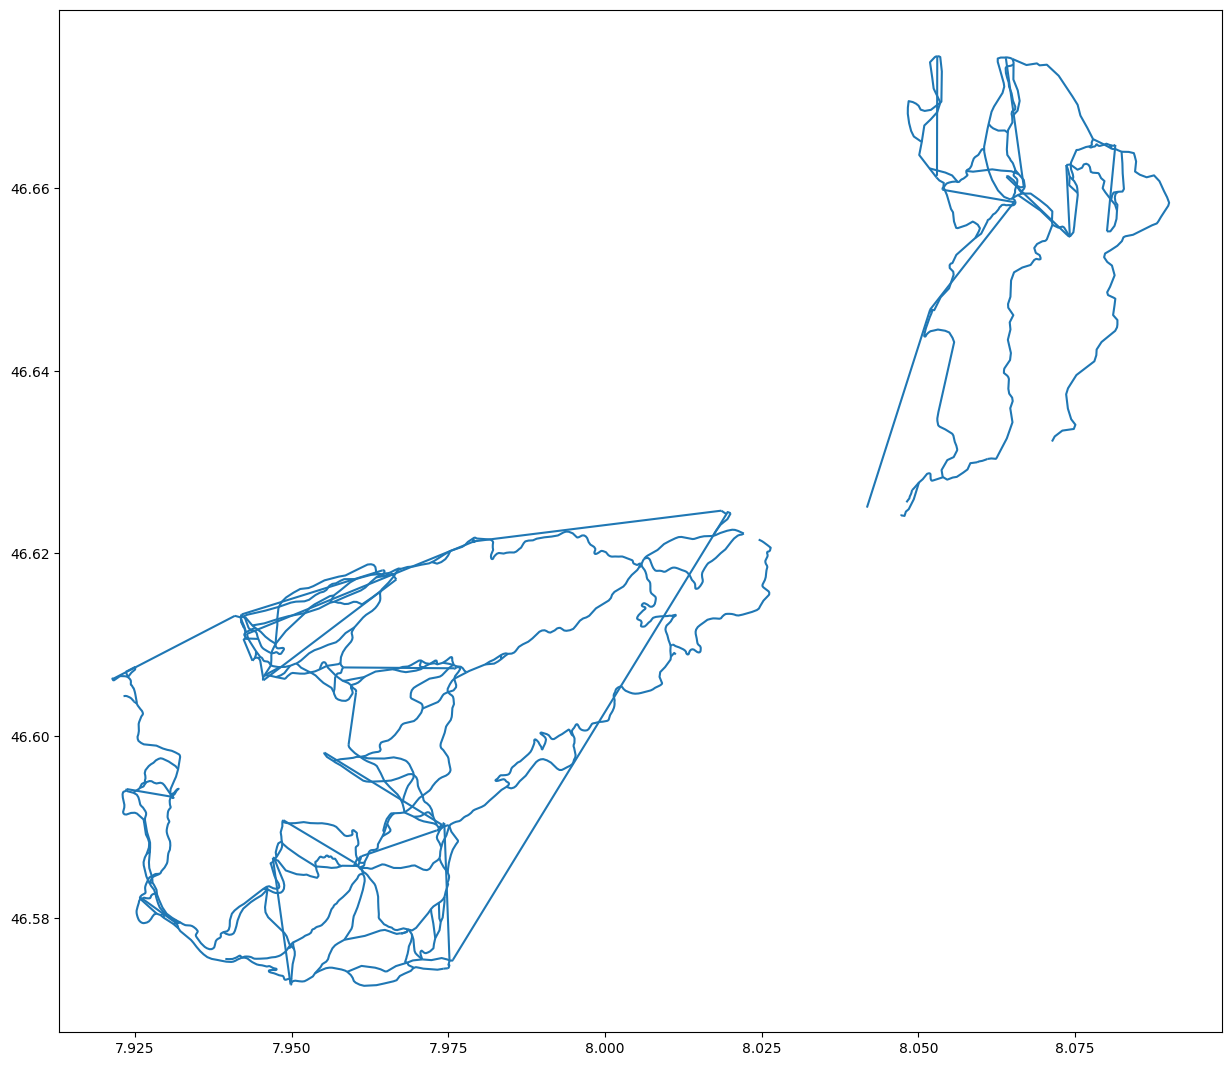

In [8]:
ski_area.geometry.plot(figsize=(15, 15))
plt.show()

### Recalculate run based metrics

In [9]:
runs = ski_area[ski_area.difficulty != 'lift']
runs = runs.rename(columns={'run_id': 'id',
                            'run_name': 'name'})

features = ["id", "name", "connection_type", "difficulty", "duration",
            "distance", "geometry", "start", "end", "status"]

# set new CRS
runs = runs.to_crs(crs)
# get length of run
runs["distance"] = runs.geometry.length
# get start coordinate
runs["start"] = runs.geometry.apply(lambda x: Point(x.coords[0]))
# get end coordinate
runs["end"] = runs.geometry.apply(lambda x: Point(x.coords[-1]))
# set connection type to run
runs["connection_type"] = "run"
# calculate duration be assuming an average speed of 25km/h or 7m/s
runs["duration"] = runs["distance"] / 7
# return defined features
#runs = runs[features]
print("Total number of runs in ski resort:", len(runs))

Total number of runs in ski resort: 172


### Recalculate lift based metrics

In [10]:
lifts = ski_area[ski_area.difficulty == 'lift']

lifts = lifts.rename(columns={'run_id': 'id',
                            'run_name': 'name'})

# set new CRS
lifts = lifts.to_crs(crs)
# get length of lift
lifts["distance"] = lifts.geometry.length
# get start coordinate
lifts["start"] = lifts.geometry.apply(lambda x: Point(x.coords[0]))
# get end coordinate
lifts["end"] = lifts.geometry.apply(lambda x: Point(x.coords[-1]))
# generate lift linesstring
lifts["geometry"] = lifts.geometry.apply(lambda x: LineString([x.coords[0], x.coords[-1]]))
# calcualte average speed in m/s (distance / duration)
mean_speed = lifts[lifts["duration"].notnull()]["distance"].sum() / lifts[lifts["duration"].notnull()].duration.sum()
lifts["duration"] = np.where(lifts["duration"].isna(), (lifts["distance"] / mean_speed), lifts["duration"])
# return defined features
lifts = lifts[features]
print("Total number of lifts in ski resort:", len(lifts))

Total number of lifts in ski resort: 28


### Concatenate runs and lifts

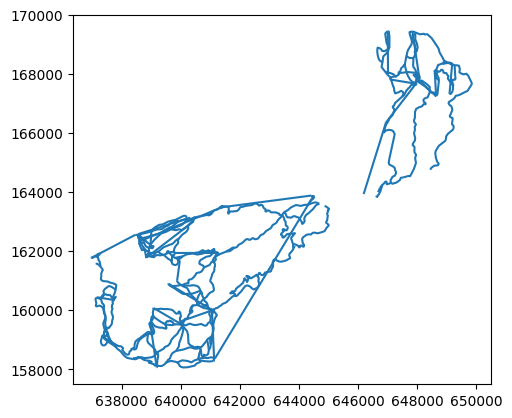

In [11]:
ski_area_data = pd.concat([lifts, runs])

ski_area_data.geometry.plot()
plt.show()

### Generate points

In [12]:
# transform linestrings to points
points = ski_area_data.geometry.apply(lambda x: x.coords).rename("point").explode().reset_index().rename(columns={"index": "Index"})
# reset index of original data, needed for merging
ski_area_data = ski_area_data.reset_index().rename(columns={"index": "Index"})
# generate unique id for each point
unique_id = []
for i in range(len(points)):
    unique_id.append(str(uuid.uuid4()))
# set point_id
points["point_id"] = unique_id
# merge points data with original data on Index
points = points.merge(ski_area_data[["id", "name", "Index", "difficulty", "duration",
                            "distance", "connection_type", "start", "end", "status"]], how="left", on="Index")
# transform points data to GeoDataFrame
points = gpd.GeoDataFrame(points, geometry=[Point(x) for x in points.point]).rename(columns={"id": "run_id"})
# get start points of all runs
start_points = points.groupby("run_id").first().reset_index()
start_points["point_type"] = "start"
# get end points of all runs
end_points = points.groupby("run_id").last().reset_index()
end_points["point_type"] = "end"
# combine start and end points
start_end_points = pd.concat([start_points, end_points], axis=0).sort_values(by="run_id")
points["points_by_run"] = points.groupby("run_id").point_id.transform("count")

### Create nodes

In [18]:
BaseRunsLiftsGraph = CreateBaseRunsLiftsGraph(points)

custom_buffer = {}
ConnectedRunsLiftsGraph = GetConnections(BaseRunsLiftsGraph, points, custom_buffer)

### Get unconnected runs and lifts

In [19]:
GetUnconnectedRunsLifts(ConnectedRunsLiftsGraph)

Unconnected start and end points: 9


[{'37b9fd49af3875c91c16a95a3fda389306bea076_1': ['Firstbahn 1', 'start']},
 {'a5d757ce1ba934682c3b2e5e054d9c698a56e89a': ['Ski run', 'start']},
 {'f7e4b4ba94d4d89cfb8e82b5c2e25494cd1925d6': ['Stepfi', 'end']},
 {'049e7ea6f0b025a3629da6994d4a3a84351bc17b': ['Ski run', 'end']},
 {'d6e778dcf9025274bef318e5deb91e4ba5700268': ['Stählisboden-Kirche', 'end']},
 {'f0eaed61f9b9b18d86a3fd8908f30aac75e9fc02': ['Ski run', 'end']},
 {'2e328807f8fbb60c9d52a5dd288a6136d67d12fc': ['Ski run', 'end']},
 {'90982a46e20932c488faa56a3f579008bba0dd52': ['Ski run', 'end']},
 {'7acfdaaa5400d12a618e8d30538b21f38dc7439f': ['Brandegg - Grindelwald Grund',
   'end']}]

### Create RunsLiftsGraph

In [ ]:
def CreateRunsLiftsGraph(RunsLiftsGraph, epsg):
    """
    Generate RunsLiftsGraph as required by the UI
    """
    RunsLiftsGraph_tmp = {"type": "FeatureCollection"}
    features = []

    project = pyproj.Transformer.from_proj(
        pyproj.Proj(init=f'epsg:{epsg}'), # source
        pyproj.Proj(init='epsg:4326')) # destination

    for run in RunsLiftsGraph:

        feature = {"type": "Feature"}
        properties = {}
        geometry = {"type": "LineString"}
        coordinates = []
        point_ids = []
        run_id = list(run.keys())[0]
        points = list(run.values())[0]
        for point in points:
            coords_wgs = transform(project.transform, point.get("point_coord"))
            coordinates.append([coords_wgs.coords[0][0], coords_wgs.coords[0][1]]) # lon, lat
            point_ids.append(point.get("point_id"))

        geometry["coordinates"] = coordinates
        properties["run_id"] = run_id
        # replace run_name with Ski run if None
        if points[0].get("run_name") is None:
            properties["run_name"] = "Ski run"
        else:
            properties["run_name"] = points[0].get("run_name")
        properties["connection_type"] = points[0].get("connection_type")
        # replace difficulty with novice if None
        if points[0].get("difficulty") is None:
            properties["difficulty"] = "novice"
        else:
            properties["difficulty"] = points[0].get("difficulty")
        # replace status with unknown if None
        if points[0].get("status") is None:
            properties["status"] = "unknown"
        else:
            properties["status"] = points[0].get("status")
        properties["duration"] = points[0].get("duration")
        properties["distance"] = points[0].get("distance")
        properties["point_id"] = point_ids
        feature["properties"] = properties
        feature["geometry"] = geometry

        features.append(feature)

    RunsLiftsGraph_tmp["features"] = features

    return RunsLiftsGraph_tmp

Final visual inspection, especially if nodes are intersections

In [28]:
RunsLiftsGraph = CreateRunsLiftsGraphwPoints(ConnectedRunsLiftsGraph, crs, difficulty_to_color)

with open (f"{dir}/RunsLiftsGraph_final_inspection.geojson", "w", encoding="utf8") as geojson_file:
    geojson_file.write(json.dumps(RunsLiftsGraph, ensure_ascii=False, indent=2))

/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [29]:
RunsLiftsGraph = CreateRunsLiftsGraph(ConnectedRunsLiftsGraph, crs)

/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## 12. Generate NodesGraph

In [25]:
def CreateTmpNodesGraph(RunsLiftsGraph):
    RunsLiftsNodesGraph = []

    for RunLift in RunsLiftsGraph:
        first_point = True
        point_counter = 0
        run_coords = []
        run_tmp = []
        last_point = len(list(RunLift.values())[0])
        for point in list(RunLift.values())[0]:
            point_counter += 1

            if point.get("run_name") is None:
                run_name = "Ski run"
            else:
                run_name = point.get("run_name")
            
            # cache start point
            if first_point == True:
                start_tmp = {"point_id": point.get("point_id"),
                            "connection_type": point.get("connection_type"),
                            "distance": point.get("distance"),
                            "duration": point.get("duration"),
                            "difficulty": point.get("difficulty"),
                            "run_name": run_name,
                            "status": point.get("status"),
                            "type": point.get("type"),
                            "point_coord": point.get("point_coord")} 


            #pointer_start = 1 # reset pointer
            run_coords.append(point.get("point_coord"))

            # reached next node or last point, calculate run length
            if (point.get("type") == "node" or point_counter == last_point) and first_point != True:
                length_segment = LineString(run_coords).length
                start_tmp["distance"] = length_segment 
                start_tmp["duration"] = point.get("duration") * (length_segment / point.get("distance"))
                start_tmp["distance_prop"] = length_segment / point.get("distance")
                run_tmp.append(start_tmp)
                run_coords = [] # reset run
                run_coords.append(point.get("point_coord")) # set new start point
                start_tmp = {"point_id": point.get("point_id"),
                            "connection_type": point.get("connection_type"),
                            "distance": point.get("distance"),
                            "duration": point.get("duration"),
                            "difficulty": point.get("difficulty"),
                            "run_name": run_name,
                            "status": point.get("status"),
                            "type": point.get("type"),
                            "point_coord": point.get("point_coord")}
            else:
                first_point = False

            # add last point
            if point_counter == last_point:
                run_tmp.append({"point_id": point.get("point_id"),
                                "connection_type": point.get("connection_type"),
                                "duration": 0.0,
                                "distance": 0.0,
                                "difficulty": point.get("difficulty"),
                                "run_name": run_name,
                                "status": point.get("status"),
                                "type": "end",
                                "point_coord": point.get("point_coord"),
                                "distance_prop": 0.0}) 

        # append modified run
        RunsLiftsNodesGraph.append({list(RunLift.keys())[0]: run_tmp})

    return RunsLiftsNodesGraph


def clean_connections(data):
    cleaned_data = []
    zero_distance_removed = 0

    for item in data:
        new_item = {}
        for key, connections in item.items():
            filtered_connections = []

            for conn in connections:
                # Remove if distance == 0.0 and not type == 'end'
                if conn['distance'] == 0.0 and conn.get('type') != 'end':
                    zero_distance_removed += 1
                    continue

                filtered_connections.append(conn)

            new_item[key] = filtered_connections
        cleaned_data.append(new_item)

    return cleaned_data, zero_distance_removed

In [ ]:
def _to_edge(node, rund_id):
        # replace difficulty with novice if None
        if node.get("difficulty") is None:
            difficulty = "novice"
        else:
            difficulty = node.get("difficulty")

        edge = {
            "run_id": rund_id,
            "run_name": node.get("run_name"),
            "duration": node.get("duration"),
            "distance": node.get("distance"),
            "difficulty": difficulty,
            "distance_prop": node.get("distance_prop")
        }
        return edge

def _get_matching_nodes(graph, connections, node_id):

        for runlift in graph:
            body = list(runlift.values())[0]

            position_counter = 0
            n_nodes = len(body) - 1
            for node in body:
                # matching point_id, not last element of run
                if node.get("point_id") == node_id and position_counter < n_nodes:

                    edge = _to_edge(node, list(runlift.keys())[0])

                    #if node already added to connections
                    next_node_id = body[position_counter+1].get("point_id")
                    if next_node_id in list(connections.keys()):

                        # if duration new node shorter than duration existing note -> replace
                        if connections.get(next_node_id).get("duration") < edge.get("duration"):
                            continue

                        else:
                            connections[body[position_counter+1].get("point_id")] = edge
                        
                    else:
                        connections[body[position_counter+1].get("point_id")] = edge

                position_counter += 1
                
        return connections

def CreateNodesGraph(RunsLiftsNodesGraph):

    NodesGraph = []
    used_nodes = []

    for runlift in RunsLiftsNodesGraph:
        body = list(runlift.values())[0]

        for node in body:

            if node.get("point_id") not in used_nodes:
                connections = {}
                connections = _get_matching_nodes(RunsLiftsNodesGraph, connections, node.get("point_id"))

            
                NodesGraph.append({"node":
                                    {node.get("point_id"):
                                    {"connected_nodes": connections}}
                                    })
            used_nodes.append(node.get("point_id"))
            
    return NodesGraph




In [ ]:
def getIncomingNodesCoords(node_graph, runslift_graph, main_node_id, lag=1):
    """
    # iterate through all nodes in NodeGraph
    for node_ in node_graph.get("features"):
        incoming_edge = {}
        main_node_id = list(node_.get("node").keys())[0]
    """
    
    incoming_edge = {}

    # iterate through all nodes to find where main_node is a connecting node -> incoming connection
    for node in node_graph.get("features"):

        # iterate through connected_nodes of each node
        for connected_node_id in list(list(node.get("node").values())[0].get("connected_nodes").keys()):
            connected_node = list(node.get("node").values())[0].get("connected_nodes").get(connected_node_id)

            # if main_node appears as connected_node of another main node -> incoming connection
            if main_node_id == connected_node_id:
                incoming_node_id = list(node.get("node").keys())[0]
                connected_node_run_id = connected_node.get("run_id")

                # iterate through all runs and lifts to find the ones where main_node is one of their points
                for runlift in runslift_graph.get("features"):

                    if runlift.get("properties").get("run_id") == connected_node_run_id:
                        
                        # enumerate through all points of run until main_node reached
                        for idx, point_id in enumerate(runlift.get("properties").get("point_id")):

                            if point_id == main_node_id:
                                # if matching point is not start point
                                if idx != 0:
                                    incoming_point_coords = runlift.get("geometry").get("coordinates")[idx - lag][:2]
                                    main_node_coords = runlift.get("geometry").get("coordinates")[idx][:2]
                                    vector_incoming = (main_node_coords[0] - incoming_point_coords[0], main_node_coords[1] - incoming_point_coords[1])
                                    incoming_edge[incoming_node_id] = vector_incoming
                                else:
                                    continue
                           
    return incoming_edge


def getOutgoingNodesCoords(node_graph, runslift_graph, main_node_id, lag=1):
    """
    # iterate through all nodes in NodeGraph
    for node_ in node_graph.get("features"):
        outgoing_edge = {}
        main_node_id = list(node_.get("node").keys())[0]
    """
    outgoing_edge = {}

    # iterate through all nodes to get connected_nodes of main_node
    for node in node_graph.get("features"):

        # if node is main_node
        if main_node_id == list(node.get("node").keys())[0]:

            # iterate through all connected nodes get connected_node_id, node body, and run_id
            for connected_node_id in list(list(node.get("node").values())[0].get("connected_nodes").keys()):
                connected_node = list(node.get("node").values())[0].get("connected_nodes").get(connected_node_id)
                connected_node_run_id = connected_node.get("run_id")

                # iterate through all runs and lifts to find the ones where main_node is one of their points
                for runlift in runslift_graph.get("features"):

                    if runlift.get("properties").get("run_id") == connected_node_run_id:
                        
                        # enumerate through all points of run until main_node reached
                        for idx, point_id in enumerate(runlift.get("properties").get("point_id")):

                            if point_id == main_node_id:
                                # if matching point is not last point get coordinates lag points before
                                if idx != len(runlift.get("properties").get("point_id")) - 1:
                                    outgoing_point_coords = runlift.get("geometry").get("coordinates")[idx + lag][:2]
                                    main_node_coords = runlift.get("geometry").get("coordinates")[idx][:2]
                                    vector_outgoing = (outgoing_point_coords[0] - main_node_coords[0], outgoing_point_coords[1] - main_node_coords[1])
                                    outgoing_edge[connected_node_id] = vector_outgoing
                                else:
                                    continue

    return outgoing_edge


def signed_angle(v1, v2):
    cross = v1[0] * v2[1] - v1[1] * v2[0]
    dot   = v1[0] * v2[0] + v1[1] * v2[1]
    return math.atan2(cross, dot)


def get_turn_direction(vector_in, vector_out):
    """
    straight_thresh_deg: treat turns smaller than this as 'Straight'
    Returns (angle_radians, direction_str).
    """
   
    # If either vector is zero‐length, we can't define a turn
    if vector_in == (0, 0) or vector_out == (0, 0):
        return 0.0, "Straight"

    angle = signed_angle(vector_in, vector_out)
    degree = math.degrees(angle)
    abs_degree = abs(degree)

    if abs_degree < 10:
        direction = "Straight"
    elif 10 <= degree < 30:
        direction = "Slightly Left"
    elif 30 <= degree < 100:
        direction = "Left"
    elif degree >= 100:
        direction = "Sharp Left"
    elif -30 < degree <= -10:
        direction = "Slightly Right"
    elif -100 < degree <= -30:
        direction = "Right"
    else:  # deg <= -100
        direction = "Sharp Right"

    return angle, direction

In [ ]:
TmpNodesGraph = CreateTmpNodesGraph(ConnectedRunsLiftsGraph)
TmpNodesGraph, duplicate_count = clean_connections(TmpNodesGraph)
print(f"Removed {duplicate_count} consecutive duplicates.")



FinalNodesGraph = CreateNodesGraph(TmpNodesGraph)
NodesGraph = {}
NodesGraph["features"] = FinalNodesGraph



for node in NodesGraph.get("features"):

    main_node_id = list(node.get("node").keys())[0]

    # derive incoming nodes and coords
    incoming_edge = getIncomingNodesCoords(NodesGraph, RunsLiftsGraph, main_node_id)

    # iterate through connected nodes get connected_node_id and body
    for connected_node_id in list(list(node.get("node").values())[0].get("connected_nodes").keys()):
        incoming_nodes = {}
        connected_node = list(node.get("node").values())[0].get("connected_nodes").get(connected_node_id)

        # derive coords of connected nodes
        outgoing_edge = getOutgoingNodesCoords(NodesGraph, RunsLiftsGraph, main_node_id)
        connected_node_vector = outgoing_edge.get(connected_node_id)

        # iterate through all incoming nodes
        for incoming_node_id in list(incoming_edge.keys()):

            angle, direction = get_turn_direction(incoming_edge.get(incoming_node_id), connected_node_vector)
            incoming_nodes[incoming_node_id] = direction

        # add all directions to connected node body
        connected_node["incoming_nodes"] = incoming_nodes

In [43]:
NodesGraph

{'features': [{'node': {'0c015445-0b98-42c0-a025-6d66cb764c26': {'connected_nodes': {'43d482e5-f002-4b95-8554-2d3e83f4857f': {'run_id': '37b9fd49af3875c91c16a95a3fda389306bea076_1',
       'run_name': 'Firstbahn 1',
       'duration': 1260.0000000801347,
       'distance': 2532.8269603872263,
       'difficulty': 'lift',
       'distance_prop': 1.000000000063599,
       'incoming_nodes': {}}}}}},
  {'node': {'43d482e5-f002-4b95-8554-2d3e83f4857f': {'connected_nodes': {'658dc4e2-81c0-4adf-a201-27f2267b6f56': {'run_id': '37b9fd49af3875c91c16a95a3fda389306bea076_2',
       'run_name': 'Firstbahn 2',
       'duration': 384.6140366659455,
       'distance': 1662.558427511255,
       'difficulty': 'lift',
       'distance_prop': 0.9999999996808417,
       'incoming_nodes': {'0c015445-0b98-42c0-a025-6d66cb764c26': {'direction': 'Slightly Right',
         'angle': -0.4148810619860642},
        '6240ec10-7d50-4e46-8ed7-634a938d0a50': {'direction': 'Sharp Right',
         'angle': -2.32146024571

## Generate ski resort manifest

## Add new ski resort to manifest

In [ ]:
# set versions and construct filename
ski_area_id_ = ski_area_id[2]
RunsLiftsGraphVersion = "1.0"
NodesGraphVersion = "1.0"
camera_coordinates = [7.980064, 46.608276]
zoom = 13.05
bearing = -122.10

In [ ]:
with open(dir_resorts + "SkiResortManifest.json", "r", encoding="utf8") as json_file:
    SkiResortManifest = json.load(json_file)

SkiResortManifest["resorts"][ski_area_id_] = {"ResortName": ski_area_name,
                                                "RunsLiftsGraphVersion": RunsLiftsGraphVersion,
                                                "NodesGraphVersion": NodesGraphVersion,
                                                "RunsLiftsGraphUpdated": datetime.date.today().strftime("%d/%m/%Y"),
                                                "NodesGraphUpdated": datetime.date.today().strftime("%d/%m/%Y"),
                                                "CameraCoordinates": camera_coordinates,
                                                "Zoom": zoom,
                                                "Bearing": bearing}

SkiResortManifest

{'resorts': {'68b126bc3175516c9263aed7635d14e37ff360dc': {'ResortName': 'Les Trois Vallées',
   'RunsLiftsGraphVersion': '1.0',
   'NodesGraphVersion': '1.0',
   'RunsLiftsGraphUpdated': '26/04/2025',
   'NodesGraphUpdated': '26/04/2025'},
  '1d111e0379650f6a9186eaa3d21dadf973340c88': {'ResortName': 'Kleine Scheidegg - Männlichen - First',
   'RunsLiftsGraphVersion': '1.0',
   'NodesGraphVersion': '1.0',
   'RunsLiftsGraphUpdated': '20/06/2025',
   'NodesGraphUpdated': '20/06/2025'}}}

In [58]:
with open (dir_resorts + "SkiResortManifest.json", "w", encoding="utf8") as json_file:
    json_file.write(json.dumps(SkiResortManifest, ensure_ascii=False, indent=2))

## Save RunsLiftsGraph and NodesGraph files

In [60]:
# add new folder for ski resort if it not already exists
folder_path = Path(f"{dir_resorts}{ski_area_id_}")
folder_path.mkdir(parents=True, exist_ok=True)

# add files
print(f"{dir_resorts}{ski_area_id_}/RunsLiftsGraph_v{RunsLiftsGraphVersion}.geojson")
with open (f"{dir_resorts}{ski_area_id_}/RunsLiftsGraph_v{RunsLiftsGraphVersion}.geojson", "w", encoding="utf8") as geojson_file:
    geojson_file.write(json.dumps(RunsLiftsGraph, ensure_ascii=False, indent=2))

print(f"{dir_resorts}{ski_area_id_}/NodesGraph_v{NodesGraphVersion}.json")
with open (f"{dir_resorts}{ski_area_id_}/NodesGraph_v{NodesGraphVersion}.json", "w", encoding="utf8") as json_file:
    json_file.write(json.dumps(NodesGraph, ensure_ascii=False, indent=2))

/Users/sebastian/Documents/PrivateProjects/SkiNavData/SkiResorts/1d111e0379650f6a9186eaa3d21dadf973340c88/RunsLiftsGraph_v1.0.geojson
/Users/sebastian/Documents/PrivateProjects/SkiNavData/SkiResorts/1d111e0379650f6a9186eaa3d21dadf973340c88/NodesGraph_v1.0.json


old code